In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tải dataset
!kaggle datasets download -d shree1992/housedata
!unzip -q housedata.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shree1992/housedata
License(s): unknown
  0% 0.00/432k [00:00<?, ?B/s]
100% 432k/432k [00:00<00:00, 849MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def load_data(path='data.csv'):
    df = pd.read_csv(path)
    return df

df = load_data()
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [ ]:
# Xử lý missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Encode các cột phân loại
label_cols = ['street', 'city', 'statezip', 'country']
for col in label_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [ ]:
# Loại bỏ outliers
upper_limit = df['sqft_living'].quantile(0.99)
df = df[df['sqft_living'] < upper_limit]

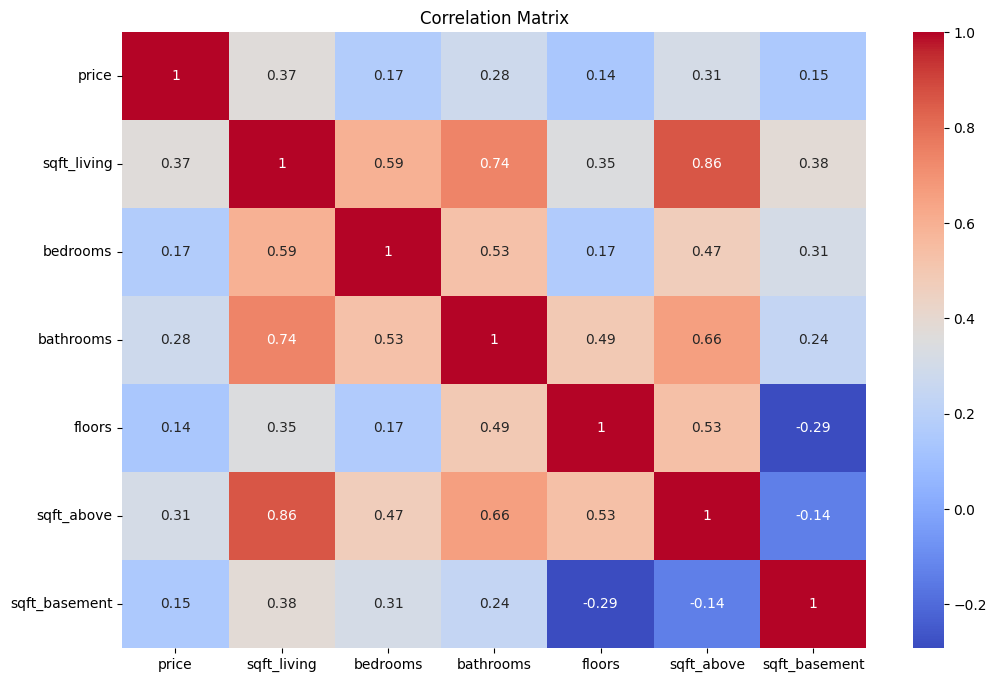

In [ ]:
# Heatmap tương quan
plt.figure(figsize=(12, 8))
selected = ['price', 'sqft_living', 'bedrooms', 'bathrooms', 'floors', 'sqft_above', 'sqft_basement']
sns.heatmap(df[selected].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

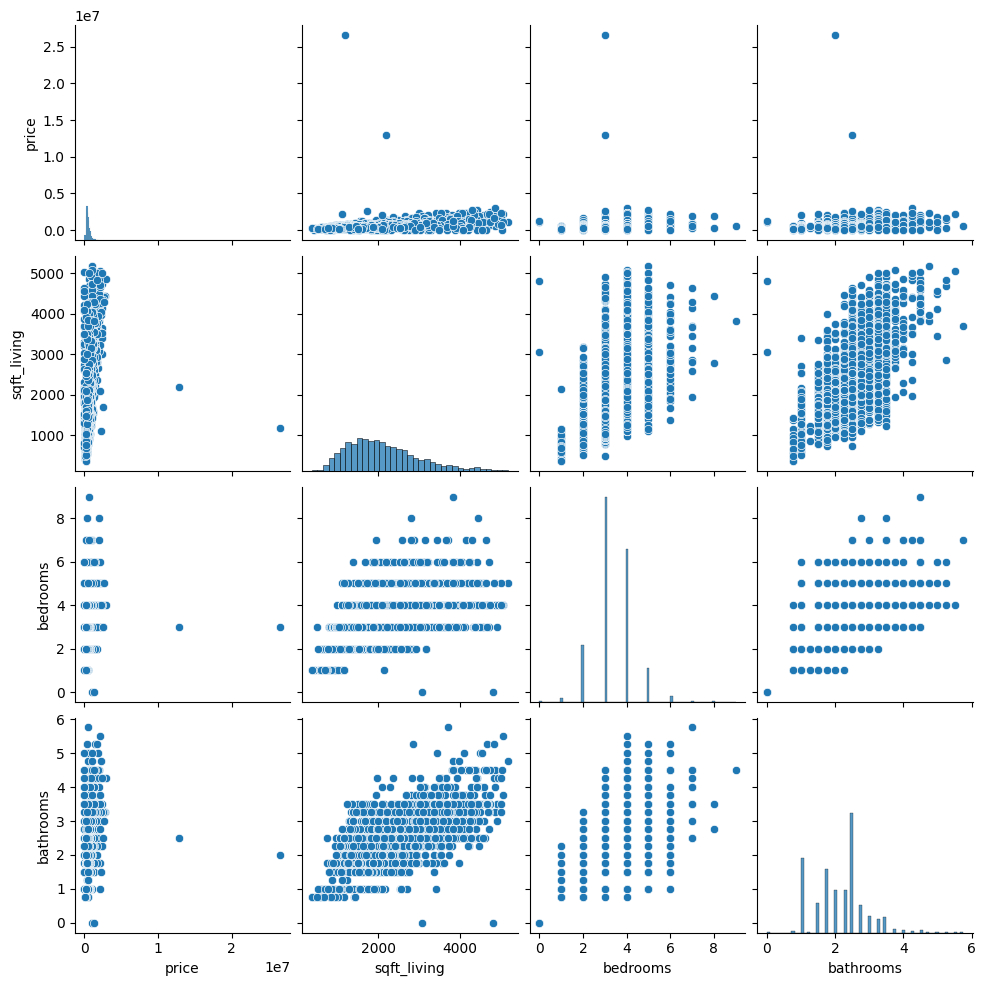

In [ ]:
# Pairplot
sns.pairplot(df[['price', 'sqft_living', 'bedrooms', 'bathrooms']])
plt.show()

In [ ]:
# Đặc trưng đầu vào và biến mục tiêu
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'waterfront', 'view', 'condition', 'sqft_above',
            'sqft_basement', 'yr_built', 'yr_renovated', 'city', 'statezip']
target = 'price'

X = df[features]
y = df[target]

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
models = {}

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
models['Linear Regression'] = linreg

# Ridge Regression
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, {'alpha': [0.01, 0.1, 1, 10]}, cv=5)
ridge_cv.fit(X_train, y_train)
models['Ridge Regression'] = ridge_cv.best_estimator_

# Lasso Regression
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, {'alpha': [0.001, 0.01, 0.1, 1]}, cv=5)
lasso_cv.fit(X_train, y_train)
models['Lasso Regression'] = lasso_cv.best_estimator_

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
models['Random Forest'] = rf

# XGBoost
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb.fit(X_train, y_train)
models['XGBoost'] = xgb

In [ ]:
results = []

for name, model in models.items():
    try:
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2})
    except Exception as e:
        print(f"Lỗi khi đánh giá {name}: {e}")
        results.append({'Model': name, 'MAE': None, 'RMSE': None, 'R2 Score': None})

results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,R2 Score
0,Linear Regression,147869.372999,216000.334343,0.497493
1,Ridge Regression,147853.577713,215987.542100,0.497553
2,Lasso Regression,147869.626293,216000.299183,0.497494
3,Random Forest,123584.091331,232063.655183,0.419974
4,XGBoost,125160.555724,399669.240173,-0.720419


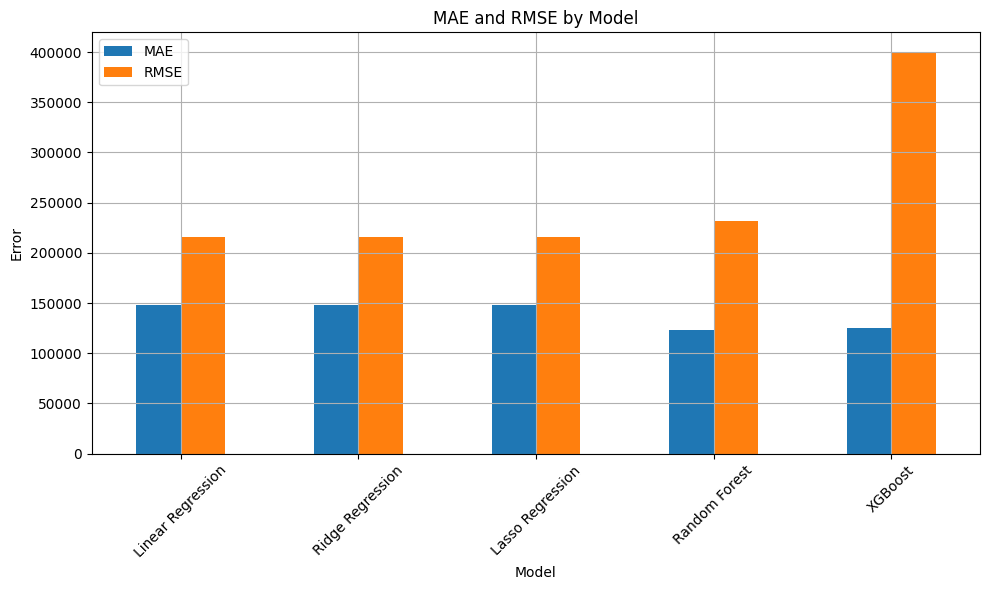

In [ ]:
# MAE và RMSE
results_df.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title("MAE and RMSE by Model")
plt.ylabel("Error")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

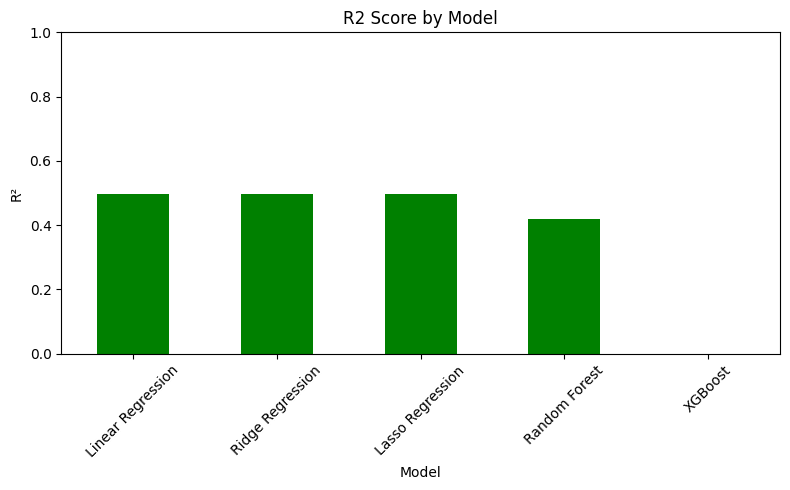

In [ ]:
# R2 Score
results_df.plot(x='Model', y='R2 Score', kind='bar', legend=False, color='green', figsize=(8, 5))
plt.title("R2 Score by Model")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()